<a href="https://colab.research.google.com/github/bd1ng/globalx/blob/main/globalx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #03
### Uses global explainability methods Partial Dependence Plots (PDP), Individual Conditional Expectation (ICE) Plots, and Accumulated Local Effects (ALE) plots to explain black-box model outputs.

### Bochu Ding

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bd1ng/globalx/blob/main/globalx.ipynb)

# 0. Set-up

In [1]:
# Install Packages #referenced global_explanations.ipynb notebook on Feb 5 @11:54p
!pip install numpy==1.25.2 pandas==2.0.3 matplotlib==3.7.1 scikit-learn==1.2.2 shap==0.45.1
!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython

  Cloning https://github.com/MaximeJumelle/ALEPython.git (to revision dev) to /tmp/pip-install-4ki28psu/alepython_72242bf29e35411fb618aaeefe2f5781
  Running command git clone --filter=blob:none --quiet https://github.com/MaximeJumelle/ALEPython.git /tmp/pip-install-4ki28psu/alepython_72242bf29e35411fb618aaeefe2f5781
  Resolved https://github.com/MaximeJumelle/ALEPython.git to commit 286350ab674980a32270db2a0b5ccca1380312a7
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 4.1 MB/s eta 0:00:00
  Created wheel for alepython: filename=alepython-0.1.dev17+g286350a-py3-none-any.whl size=15139 sha256=161b7c33618f037885c3db4111a511dbc4124d3f6171ef600173625f0f2cdb8b
  Stored in directory: /tmp/pip-ephem-wheel-cache-q074d4dp/wheels/ac/d2/e4/cd88ce55641d5422cdba165bd6f18c6fb6c0035385dc2bcce2
Successfully built alepython


In [10]:
# Import Libraries #referenced global_explanations.ipynb notebook on Feb 5 @11:54p

# Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Models
import xgboost
from sklearn.model_selection import train_test_split

# XAI
import shap
from alepython import ale_plot
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

np.random.seed(1)


In [11]:
# Load Data from shap library #referenced global_explanations.ipynb notebook on Feb 5 @11:56p
X,y = shap.datasets.adult()

# Train XGBoost model #referenced global_explanations.ipynb notebook on Feb 5 @11:56p
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
model = xgboost.XGBClassifier().fit(X_train, y_train)

# 1. Exploratory Analysis

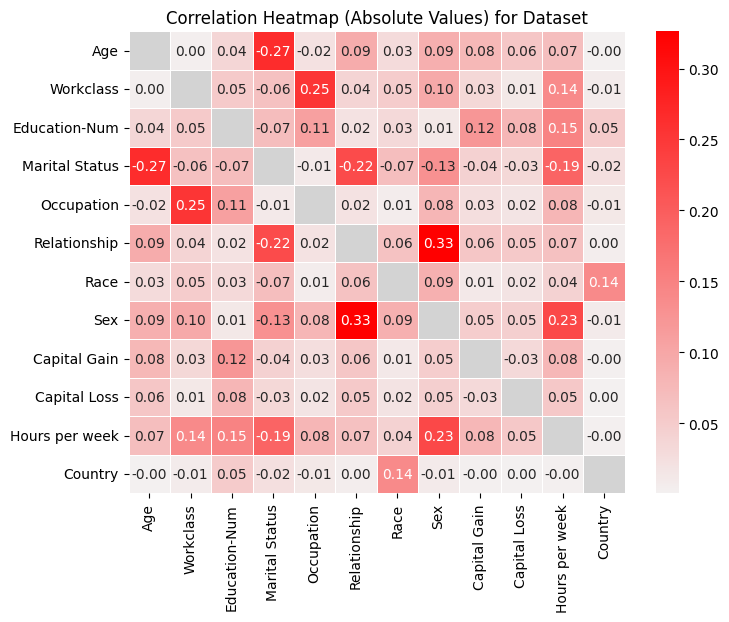

In [29]:
df = pd.DataFrame(X) #tuple-to-dataframe transformation with help of ChatGPT on Feb 6 @12:01a
corr_matrix = df.corr()
corr_matrix_display = df.corr().abs() #absolute-value transformation for easier identification with help of ChatGPT on Feb 6 @12:11a

np.fill_diagonal(corr_matrix_display.values, np.nan) #diagonal removal for easier interpretation with help of ChatGPT on Feb 6 @12:11a

plt.figure(figsize=(8, 6))

cmap = sns.light_palette("red", as_cmap=True)

cmap.set_bad(color="lightgray") #troubleshoot diagonal with help of ChatGPT on Feb 6 @12:20a
sns.heatmap(corr_matrix_display, annot=corr_matrix, cmap=cmap, fmt=".2f", linewidths=0.5) #beautification with help of ChatGPT on Feb 6 @12:04a, updated @12:12a

plt.title('Correlation Heatmap (Absolute Values) for Dataset')
plt.show()

Interpretation: There are some fairly intuitive correlations within this dataset. For example, Work Class and Occupation are tightly correlated. (Working) Hours per Week had several moderate correlations, including Work Class, Education (Number of Years), Marital Status, and Sex. The most significant correlations within the dataset seem to largely relate to Marital Status, which is intuitively correlated with Age and Relationship. Less clear is its relationship with sex and (Working) Hours per Week.



# 1. Partial Dependence Plots (PDP)

Text(0.5, 0.98, 'Both')

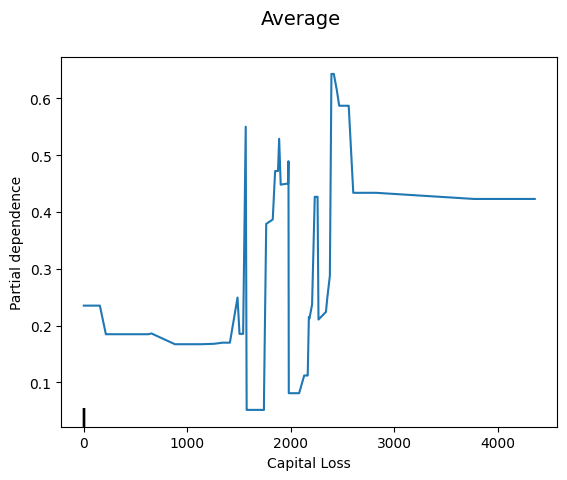

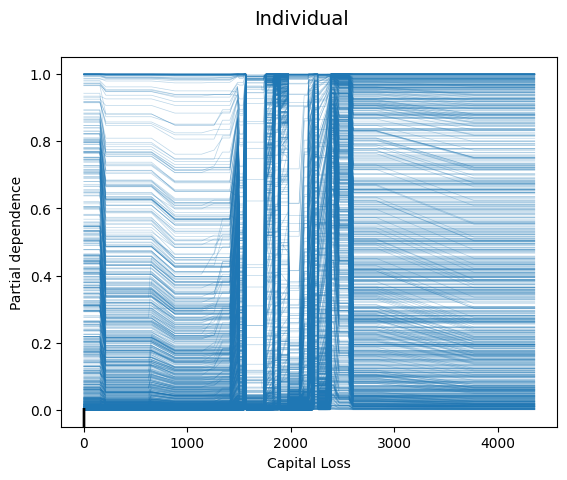

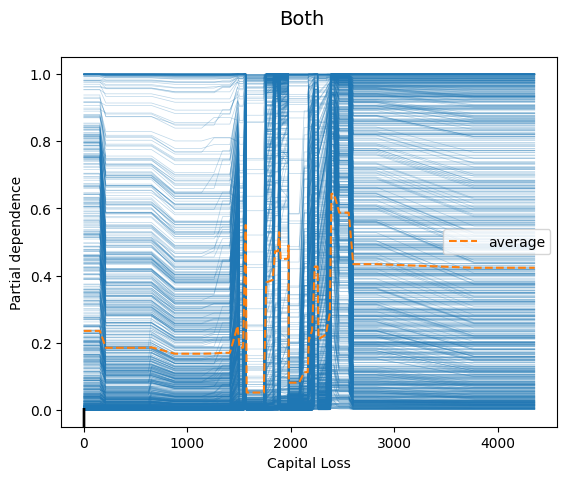

In [30]:
#referenced global_explanations.ipynb notebook on Feb 6 @12:31a
features = ["Capital Loss"]

# Plot Partial Dependence Plot for Capital Loss; tapped in ChatGPT to figure out what the different "kind" configurations meant @12:32a
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='average')
plt.suptitle("Average", fontsize=14)
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='individual')
plt.suptitle("Individual", fontsize=14)
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='both')
plt.suptitle("Both", fontsize=14)

Interpretation: This partial dependence plot is somewhat erratic; it has semblances of a linear relationship, with lower values from [0, 1500] and higher values from [2500, 4500]. The area in between (i.e. [1500, 2500]) behaves irregularly with several extreme peaks and valleys. Ignoring the erratic zone, the PDP suggests that a higher value of capital loss positively affects the prediction (and vice versa). Notably, the plateaus at these two ends suggest that there are threshold values between [0, 1500] and [2500, 4500], where further increases do not have meaningful effects on predictions. I would have surprised a more clear linear relationship, given that capital loss should have bearing on income (albeit depending on the definition of both categories). I suspect that there might be extreme values or outliers that are impacting the smoothing of the PDP's curve.

(Referenced global_explanations notebook for interpretation framework. No other external references consulted)

# 2. Accumulated Local Effects (ALE) Plots

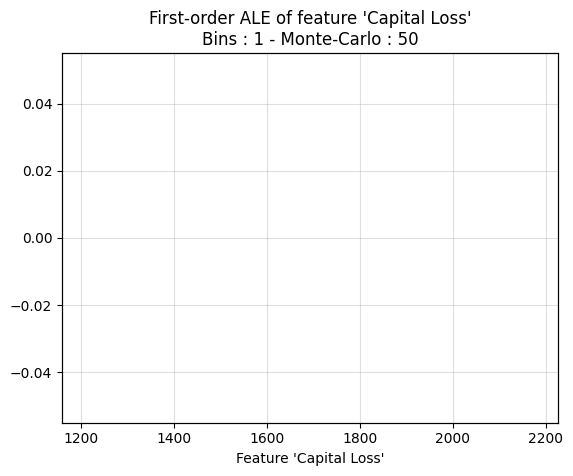

<Axes: title={'center': "First-order ALE of feature 'Capital Loss'\nBins : 1 - Monte-Carlo : 50"}, xlabel="Feature 'Capital Loss'">

In [35]:
# 1D Main Effect ALE Plot with default parameters; referenced global_explanations.ipynb notebook on Feb 6 @1:15a
ale_plot(model, X_train, 'Capital Loss', monte_carlo=True)

Interpretation: There are likely far too many zero values, causing ALE to not find enough variation to calculate effects.

Solution: Choose a different variable.

(Queried ChatGPT on Feb 6 @1:19a)

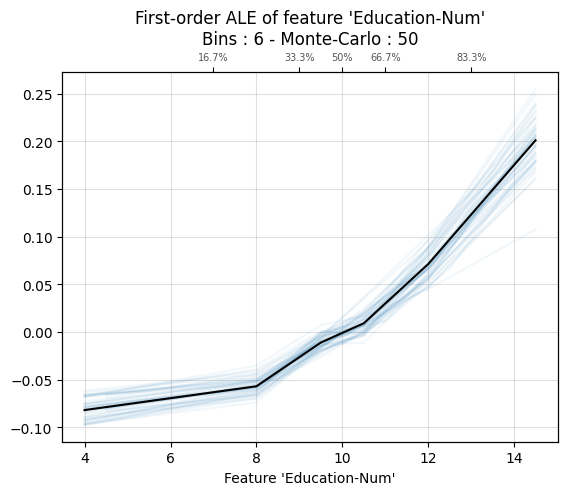

<Axes: title={'center': "First-order ALE of feature 'Education-Num'\nBins : 6 - Monte-Carlo : 50"}, xlabel="Feature 'Education-Num'">

In [38]:
# 1D Main Effect ALE Plot with default parameters pt. 2
ale_plot(model, X_train, 'Education-Num', monte_carlo=True)

Woo-hoo! This one is normal. Thank god.

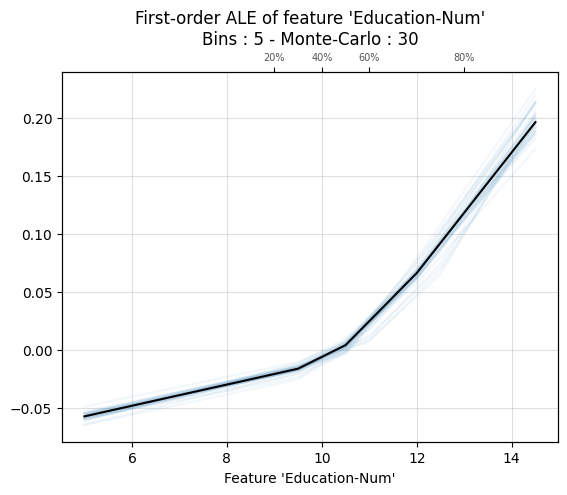

<Axes: title={'center': "First-order ALE of feature 'Education-Num'\nBins : 5 - Monte-Carlo : 30"}, xlabel="Feature 'Education-Num'">

In [39]:
# ALE Plot with new hyperparameters; referenced global_explanations.ipynb notebook on Feb 6 @1:22a
ale_plot(
    model,
    X_train,
    "Education-Num",
    bins=7,
    monte_carlo=True,
    monte_carlo_rep=30,
    monte_carlo_ratio=0.5,
)

Interpretation: Education has a significant effect on the predictions, given the steep curve of the feature's accumulated local effects. The curve is also upward sloping, which indicates an increasing effect on model predictions.  This intuitively makes sense given the conferral of degrees at specific education milestone years.

(Referenced global_explanations notebook for interpretation framework. No other external references consulted)

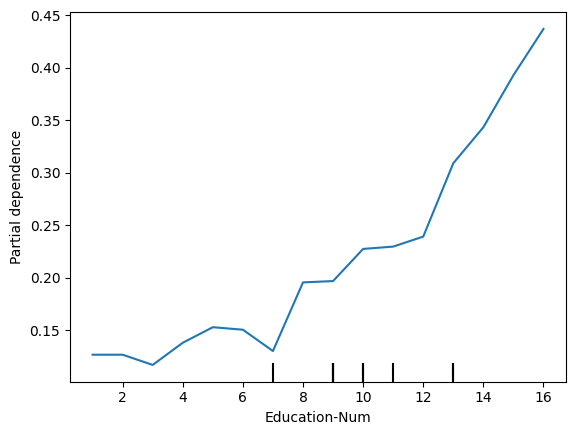

In [40]:
#PDP of Education-Num for comparison purposes
features_edu = ["Education-Num"]
PartialDependenceDisplay.from_estimator(model, X_test, features_edu, kind='average')

Divergences from ALE Plot: The PDP plot exhibits similar curvature to the ALE plot, but is more jagged. This may be due to PDP's sensitivity to outliers, as well as more extreme values generated due to correlation between features. In the case of education, a feature that is only lightly correlated with other features, the two plots generally converge. For features with stronger correlations with other features, such as age, it may be more accurate to rely on the ALE plot than the PDP plot.

(Referenced global_explanations notebook for interpretation framework. No other external references consulted.)




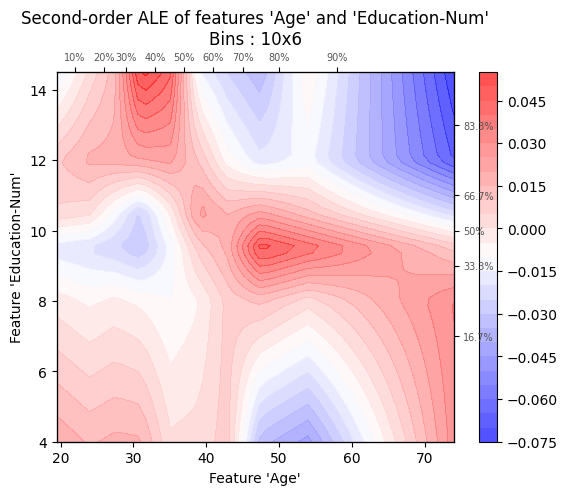

<Axes: title={'center': "Second-order ALE of features 'Age' and 'Education-Num'\nBins : 10x6"}, xlabel="Feature 'Age'", ylabel="Feature 'Education-Num'">

In [42]:
# 2D Second-Order ALE Plot; referenced global_explanations.ipynb notebook on Feb 6 @1:26a
ale_plot(model, X_train, ['Age','Education-Num'], bins=10) # troubleshooted with help of ChatGPT on Feb 6 @1:31a

Interpretation: The peaks and valleys of the second-order ALE plot highlight where the joint effect of two features have the most significant effects on model predictions. The three notable points are mid-career individuals with highly advanced (assuming doctoral) degrees, senior-career individuals with advanced degrees, and older individuals with advanced degrees. The results of this plot are intuitive and can be mapped onto certain assumed demographic personas, namely: highly technical mid-career professionals, senior career professionals in management positions, and highly educated individuals who have retired (and hence have little-to-no income).

*(These interpretations are subject to the definition of parameters, which aren't very clear.)*

(Referenced global_explanations notebook for interpretation framework. No other external references consulted.)

# 3. Individual Conditional Expectation (ICE)

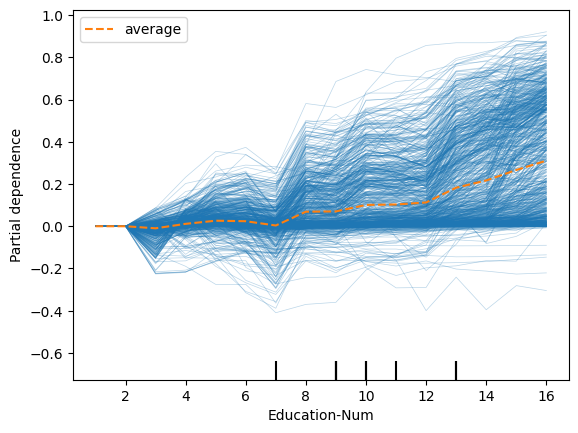

In [43]:
PartialDependenceDisplay.from_estimator(model, X_test, features_edu, kind='both', centered=True)

Interpretation: As age number of years of education increases, the predicted probability of income >=$50K increases. However, we can also observe a dense set of lines that remain flat — this suggests that there are interactive effects between education and another feature.

(Referenced local_explanations notebook for interpretation framework, as well as ChatGPT for detailed explanations on Feb 6 @1:22a. No other external references consulted.)